In [ ]:
!pip install statsmodels

# 데이터를 통해 forward, backward, stepwise 모두 진행

In [3]:
import pandas as pd
missing_to_median=pd.read_csv("data_median.csv")    
missing_to_drop = pd.read_csv("data_drop.csv")

data_median = missing_to_median.drop(columns="TARGET")
target_median = missing_to_median["TARGET"]
data_drop = missing_to_drop.drop(columns="TARGET")
target_drop = missing_to_drop["TARGET"]


In [9]:
target_drop

0         1
1         0
2         0
3         0
4         0
         ..
167725    0
167726    0
167727    0
167728    1
167729    0
Name: TARGET, Length: 167730, dtype: int64

In [ ]:
# # 데이터 샘플링 (예: 20% 샘플 사용)
# data_sampled = data.sample(frac=0.3, random_state=42)  # 10% 샘플링
# target_sampled = target.loc[data_sampled.index]

## 존나 느린 모델들 정의

In [5]:
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

def forward_selection(data, target, cv=3):
    # Naive Bayes 모델 정의
    model = GaussianNB()
    
    # Stratified K-Fold 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # roc_auc 스코어 설정
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
    
    # SequentialFeatureSelector 설정
    sfs = SequentialFeatureSelector(
        model,
        k_features="best",         # 최적의 feature 수를 자동으로 선택
        forward=True,              # Forward Selection
        floating=False,            # Floating 옵션 비활성화
        scoring=roc_auc_scorer,    # 모델 평가 기준을 roc_auc로 설정
        cv=cv_strategy,            # 계층적 KFold 사용
        n_jobs=5                  # 병렬 처리
    )

    # Forward Selection 실행
    print("Naive Bayes로 Forward Selection 시작\n")
    all_scores = []  # 각 단계의 성능 기록

    for feature_count in range(1, data.shape[1] + 1):
        sfs.k_features = feature_count
        sfs = sfs.fit(data.values, target.values)

        # 선택된 Feature와 평가 점수 기록
        selected_features = list(data.columns[list(sfs.k_feature_idx_)])
        mean_score = sfs.k_score_
        all_scores.append((feature_count, selected_features, mean_score))

        # 현재 단계 출력
        print(f"Step {feature_count}: Selected Features - {selected_features}")
        print(f"    Mean ROC AUC Score: {mean_score:.4f}\n")

    # 최종 결과 출력
    print("최종 선택된 Features:")
    final_features = data.columns[list(sfs.k_feature_idx_)]
    print(final_features.tolist())
    
    return all_scores


In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Backward Elimination 함수 정의
def backward_elimination(data, target, cv=3):
    # Naive Bayes 모델 정의
    model = GaussianNB()

    # Stratified K-Fold 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # ROC AUC 스코어 정의
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # 현재 특성 집합
    current_features = list(data.columns)
    all_scores = []  # 각 단계의 성능 기록

    print("Backward Elimination 시작\n")

    while len(current_features) > 1:
        scores = []
        feature_to_remove = None

        # 각 특성을 제거해보며 평가
        for feature in current_features:
            temp_features = [f for f in current_features if f != feature]
            X_temp = data[temp_features]

            # 교차 검증으로 ROC AUC 계산
            cv_scores = []
            for train_idx, test_idx in cv_strategy.split(X_temp, target):
                model.fit(X_temp.iloc[train_idx], target.iloc[train_idx])
                proba = model.predict_proba(X_temp.iloc[test_idx])
                cv_scores.append(roc_auc_score(target.iloc[test_idx], proba, multi_class='ovr'))

            mean_score = np.mean(cv_scores)
            scores.append((feature, mean_score))

        # 가장 성능이 낮은 특성 제거
        scores.sort(key=lambda x: x[1], reverse=True)  # 성능 기준 정렬
        feature_to_remove = scores[-1][0]  # 가장 낮은 성능의 특성
        current_features.remove(feature_to_remove)

        # 현재 단계 기록
        best_score = scores[-1][1]
        all_scores.append((len(current_features), list(current_features), best_score))

        print(f"Removed Feature: {feature_to_remove}")
        print(f"Remaining Features: {current_features}")
        print(f"    Mean ROC AUC Score: {best_score:.4f}\n")

    print("최종 선택된 Features:")
    print(current_features)
    return all_scores


In [8]:
def stepwise_selection(data, target, cv=5):
    # Logistic Regression 모델 정의
    model = LogisticRegression(max_iter=1000, random_state=42)

    # StratifiedKFold를 사용하여 교차 검증 설정
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # roc_auc 스코어 설정
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # SequentialFeatureSelector 설정
    sfs = SequentialFeatureSelector(
        model,
        k_features="best",         # 최적의 feature 수를 자동으로 선택
        forward=True,              # Forward Selection 기반
        floating=True,             # Stepwise Selection 활성화
        scoring=roc_auc_scorer,    # 모델 평가 기준을 roc_auc로 설정
        cv=cv_strategy,            # 계층적 KFold 사용
        n_jobs=-1                  # 병렬 처리
    )

    # Stepwise Selection 실행
    print("Stepwise Selection 시작\n")
    all_scores = []  # 각 단계의 성능 기록

    for feature_count in range(1, data.shape[1] + 1):
        sfs.k_features = feature_count
        sfs = sfs.fit(data.values, target.values)

        # 선택된 Feature와 평가 점수 기록
        selected_features = list(data.columns[list(sfs.k_feature_idx_)])
        mean_score = sfs.k_score_
        all_scores.append((feature_count, selected_features, mean_score))

        # 현재 단계 출력
        print(f"Step {feature_count}: Selected Features - {selected_features}")
        print(f"    Mean ROC AUC Score: {mean_score:.4f}\n")

    # 최종 결과 출력
    print("최종 선택된 Features:")
    final_features = data.columns[list(sfs.k_feature_idx_)]
    print(final_features.tolist())
    
    return all_scores


## 유빈햄의 빠른 실행 코드

In [4]:
import statsmodels.api as sm
# Backward Selection 함수 정의
def backward_selection(X, y, significance_level=0.05):
    """
    Backward Selection Algorithm
    :param X: 독립 변수 데이터프레임
    :param y: 종속 변수 시리즈
    :param significance_level: 제거 기준 p-value (default: 0.05)
    :return: 선택된 변수 리스트
    """
    X = sm.add_constant(X)  # 상수항 추가
    selected_features = list(X.columns)
    
    while len(selected_features) > 0:
        X_selected = X[selected_features]
        model = sm.OLS(y, X_selected).fit()
        p_values = model.pvalues.iloc[1:]  # 상수항 제외
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            selected_features.remove(excluded_feature)
            print(f"제거된 변수: {excluded_feature}, p-value: {max_p_value}")
        else:
            break
    
    return selected_features

# Backward Selection 실행
selected_features = backward_selection(data_drop, target_drop)
print("\n선택된 변수:", selected_features)

제거된 변수: AMT_REQ_CREDIT_BUREAU_WEEK, p-value: 0.8716359214538494
제거된 변수: AMT_REQ_CREDIT_BUREAU_HOUR, p-value: 0.8487593657958953
제거된 변수: LIVE_REGION_NOT_WORK_REGION, p-value: 0.7656208473721549
제거된 변수: OBS_30_CNT_SOCIAL_CIRCLE, p-value: 0.657505600857905
제거된 변수: OBS_60_CNT_SOCIAL_CIRCLE, p-value: 0.5954160000541401
제거된 변수: NAME_INCOME_TYPE_3.0, p-value: 0.41419287097752877
제거된 변수: LIVE_CITY_NOT_WORK_CITY, p-value: 0.37222206967143157
제거된 변수: AMT_REQ_CREDIT_BUREAU_MON, p-value: 0.36045899962382266
제거된 변수: FLAG_CONT_MOBILE, p-value: 0.3276931680906603
제거된 변수: AMT_REQ_CREDIT_BUREAU_DAY, p-value: 0.26428455719520205
제거된 변수: FLAG_EMP_PHONE, p-value: 0.2592423666554049
제거된 변수: REG_CITY_NOT_WORK_CITY, p-value: 0.15365974359154877
제거된 변수: REG_REGION_NOT_WORK_REGION, p-value: 0.18434071613620562
제거된 변수: NAME_INCOME_TYPE_2.0, p-value: 0.11424560837682952
제거된 변수: FLAG_EMAIL, p-value: 0.07226896214141157

선택된 변수: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN

In [12]:
import statsmodels.api as sm

# Forward Selection 함수 정의
def forward_selection_fast(X, y, significance_level=0.05):
    """
    Forward Selection Algorithm
    :param X: 독립 변수 데이터프레임
    :param y: 종속 변수 시리즈
    :param significance_level: 포함 기준 p-value (default: 0.05)
    :return: 선택된 변수 리스트
    """
    initial_features = []  # 초기 선택된 변수는 없음
    remaining_features = list(X.columns)  # 모든 변수는 처음엔 후보군
    selected_features = []

    print("Forward Selection 시작\n")

    while remaining_features:
        best_p_value = float('inf')
        best_feature = None

        # 남은 변수 중 하나씩 추가해가며 평가
        for feature in remaining_features:
            features_to_test = initial_features + [feature]
            X_selected = sm.add_constant(X[features_to_test])  # 상수항 추가
            model = sm.OLS(y, X_selected).fit()
            p_value = model.pvalues[feature]  # 새로 추가된 변수의 p-value

            if p_value < best_p_value:
                best_p_value = p_value
                best_feature = feature

        # 선택 기준을 충족하면 변수 추가
        if best_p_value < significance_level:
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            selected_features.append(best_feature)
            print(f"추가된 변수: {best_feature}, p-value: {best_p_value:.4f}")
        else:
            break

    print("\n선택된 변수:", selected_features)
    return selected_features
forward_selection_fast(data_drop,target_drop)

Forward Selection 시작

추가된 변수: FLAG_MOBIL, p-value: 0.0000
추가된 변수: EXT_SOURCE_2, p-value: 0.0000
추가된 변수: DAYS_EMPLOYED, p-value: 0.0000
추가된 변수: NAME_EDUCATION_TYPE, p-value: 0.0000
추가된 변수: ORGANIZATION_TYPE, p-value: 0.0000
추가된 변수: FLAG_DOCUMENT_3, p-value: 0.0000
추가된 변수: CODE_GENDER, p-value: 0.0000
추가된 변수: FLAG_OWN_CAR, p-value: 0.0000
추가된 변수: DAYS_BIRTH, p-value: 0.0000
추가된 변수: DEF_30_CNT_SOCIAL_CIRCLE, p-value: 0.0000
추가된 변수: DAYS_ID_PUBLISH, p-value: 0.0000
추가된 변수: REG_CITY_NOT_LIVE_CITY, p-value: 0.0000
추가된 변수: AMT_REQ_CREDIT_BUREAU_YEAR, p-value: 0.0000
추가된 변수: DAYS_LAST_PHONE_CHANGE, p-value: 0.0000
추가된 변수: REGION_RATING_CLIENT_W_CITY, p-value: 0.0000
추가된 변수: NAME_CONTRACT_TYPE, p-value: 0.0000
추가된 변수: FLAG_WORK_PHONE, p-value: 0.0000
추가된 변수: DAYS_REGISTRATION, p-value: 0.0000
추가된 변수: NAME_INCOME_TYPE_1.0, p-value: 0.0000
추가된 변수: NAME_TYPE_SUITE, p-value: 0.0000
추가된 변수: AMT_INCOME_TOTAL, p-value: 0.0000
추가된 변수: REGION_POPULATION_RELATIVE, p-value: 0.0001
추가된 변수: AMT_REQ_CREDIT_B

['FLAG_MOBIL',
 'EXT_SOURCE_2',
 'DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_3',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'DAYS_BIRTH',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_LIVE_CITY',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_CONTRACT_TYPE',
 'FLAG_WORK_PHONE',
 'DAYS_REGISTRATION',
 'NAME_INCOME_TYPE_1.0',
 'NAME_TYPE_SUITE',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'NAME_HOUSING_TYPE',
 'FLAG_OWN_REALTY',
 'NAME_FAMILY_STATUS_2',
 'REGION_RATING_CLIENT',
 'WEEKDAY_APPR_PROCESS_START']

In [13]:
# 최종 모델 학습
def fit_final_model(X, y, selected_features):
    """
    선택된 변수로 최종 모델 학습
    :param X: 독립 변수 데이터프레임
    :param y: 종속 변수 시리즈
    :param selected_features: 선택된 변수 리스트
    :return: 학습된 statsmodels 모델
    """
    X_selected = sm.add_constant(X[selected_features])  # 상수항 추가
    final_model = sm.OLS(y, X_selected).fit()
    return final_model

# Forward Selection으로 변수 선택
selected_features = forward_selection_fast(data_drop, target_drop)

# 최종 모델 학습
final_model = fit_final_model(data_drop, target_drop, selected_features)

# 최종 모델 결과 출력
print(final_model.summary())


Forward Selection 시작

추가된 변수: FLAG_MOBIL, p-value: 0.0000
추가된 변수: EXT_SOURCE_2, p-value: 0.0000
추가된 변수: DAYS_EMPLOYED, p-value: 0.0000
추가된 변수: NAME_EDUCATION_TYPE, p-value: 0.0000
추가된 변수: ORGANIZATION_TYPE, p-value: 0.0000
추가된 변수: FLAG_DOCUMENT_3, p-value: 0.0000
추가된 변수: CODE_GENDER, p-value: 0.0000
추가된 변수: FLAG_OWN_CAR, p-value: 0.0000
추가된 변수: DAYS_BIRTH, p-value: 0.0000
추가된 변수: DEF_30_CNT_SOCIAL_CIRCLE, p-value: 0.0000
추가된 변수: DAYS_ID_PUBLISH, p-value: 0.0000
추가된 변수: REG_CITY_NOT_LIVE_CITY, p-value: 0.0000
추가된 변수: AMT_REQ_CREDIT_BUREAU_YEAR, p-value: 0.0000
추가된 변수: DAYS_LAST_PHONE_CHANGE, p-value: 0.0000
추가된 변수: REGION_RATING_CLIENT_W_CITY, p-value: 0.0000
추가된 변수: NAME_CONTRACT_TYPE, p-value: 0.0000
추가된 변수: FLAG_WORK_PHONE, p-value: 0.0000
추가된 변수: DAYS_REGISTRATION, p-value: 0.0000
추가된 변수: NAME_INCOME_TYPE_1.0, p-value: 0.0000
추가된 변수: NAME_TYPE_SUITE, p-value: 0.0000
추가된 변수: AMT_INCOME_TOTAL, p-value: 0.0000
추가된 변수: REGION_POPULATION_RELATIVE, p-value: 0.0001
추가된 변수: AMT_REQ_CREDIT_B

## 실행결과

In [10]:

# Forward Selection 실행
selected_features = forward_selection(data_drop, target_drop)

c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Naive Bayes로 Forward Selection 시작



c:\Python312\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:800: RuntimeWarning: Mean of empty slice
  all_avg_scores.append(np.nanmean(cv_scores))


Step 1: Selected Features - ['FLAG_MOBIL']
    Mean ROC AUC Score: nan

Step 2: Selected Features - ['FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6556

Step 3: Selected Features - ['DAYS_EMPLOYED', 'FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6652

Step 4: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6690

Step 5: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2']
    Mean ROC AUC Score: 0.6708

Step 6: Selected Features - ['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE']
    Mean ROC AUC Score: 0.6732

Step 7: Selected Features - ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE']
    Mean ROC AUC Score: 0.6758

Step 8: Selected Features - ['CODE_GENDER', '

variable_list = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
    'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
    'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_INCOME_TYPE_1.0', 'NAME_INCOME_TYPE_2.0',
    'NAME_INCOME_TYPE_3.0', 'NAME_FAMILY_STATUS_2', 'NAME_FAMILY_STATUS_3'
]

In [7]:
# backward_selection 실행
backward_elimination(data_drop, target_drop)

c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Backward Elimination 시작



ValueError: y should be a 1d array, got an array of shape (55910, 2) instead.

In [ ]:
stepwise_selection(data_median, target_median)

Selected features: ('NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',

## 변수 선택 전 기본 모델 성능 확인

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(data_median, target_median, test_size=0.3, random_state=42)


array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# statsmodels 학습모델 구축
lr = sm.Logit(y_train, X_train)

# 모델 적합
result = lr.fit()
result.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [20]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

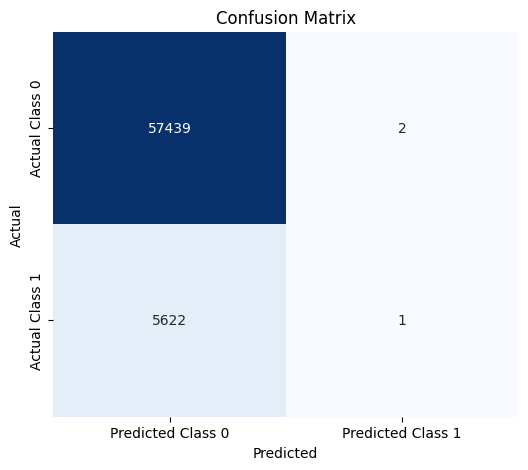


Evaluation Metrics:
Recall: 0.911
Precision: 0.859
F1 Score: 0.868


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# 2. 예측
y_pred = model.predict(X_test)  # X_test로 예측값 생성
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Class 0', 'Predicted Class 1'], 
            yticklabels=['Actual Class 0', 'Actual Class 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Recall, Precision, F1 Score
recall = recall_score(y_test, y_pred, average='weighted')   # 'weighted'는 클래스 불균형 고려
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nEvaluation Metrics:")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")